# Predict `Subject Age`

In [1]:
%matplotlib inline

In [2]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax, GlobalAveragePooling2D
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
import time
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
# %config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = [9,6]

In [4]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
phenotype = 'Subject Age'

In [6]:
#load data
aging_dir = Path('/home/ubuntu/a/aging')

with open(aging_dir/'aging-cytof-data.obj', 'rb') as f:
    allData = pickle.load(f)
samples = allData["samples"]
cyto_data = allData['expr_list']
# Truncate cytodata
cyto_data = cyto_data[ :, :int(5e3)]
markers = allData["marker_names"]

print(f'Dimensions of cyto_data: {cyto_data.shape}')
print(f'Dimensions of samples: {samples.shape}')
print(f'Names of the makers: {markers.values}')

Dimensions of cyto_data: (260, 5000, 27, 1)
Dimensions of samples: (260, 85)
Names of the makers: ['CELL_LENGTH' 'DEAD' 'CD19' 'CD4' 'CD8' 'IGD' 'CD85J' 'CD16' 'CD3' 'CD38'
 'CD27' 'CD14' 'CD94' 'CCR7' 'CD45RA' 'CD20' 'CD127' 'CD33' 'CD28' 'CD24'
 'CD161' 'TCRGD' 'CD56' 'HLADR' 'CD25' 'DNA1' 'DNA2']


count    260.000000
mean      68.303846
std       15.169696
min       41.000000
25%       55.000000
50%       69.000000
75%       82.000000
max       90.000000
Name: Subject Age, dtype: float64


<AxesSubplot:ylabel='Frequency'>

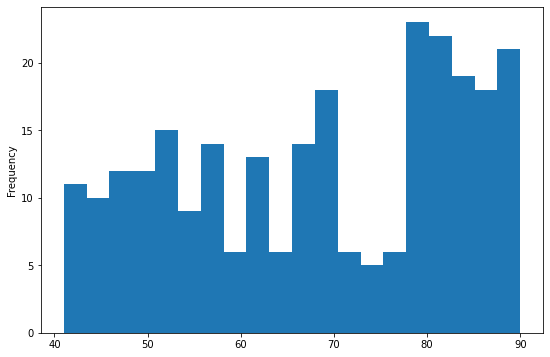

In [7]:
print(samples[phenotype].describe())
samples[phenotype].plot.hist(bins=20)

In [8]:
##### Step 3: split train, validation and test######
x = []
y = []
for i, row in samples.iterrows():
    x.append(cyto_data[i])
    y.append(row[phenotype])
age_range = max(y) - min(y)
x = np.asarray(x)
y_raw = np.asarray(y)

x_train, x_valid, y_train, y_valid = train_test_split(x, y_raw, train_size=0.75)

scaler = MinMaxScaler()

scaler.fit(y_train.reshape(-1,1))
y_train = scaler.transform(y_train.reshape(-1,1)).reshape(1,-1)[0]
y_valid = scaler.transform(y_valid.reshape(-1,1)).reshape(1,-1)[0]
print(x_train.shape, x_valid.shape)

(195, 5000, 27, 1) (65, 5000, 27, 1)


In [9]:
model = Sequential([
    Input(shape=x[0].shape),
    Conv2D(4, kernel_size = (1, x.shape[2]), activation=None),
    BatchNormalization(),
    Activation('relu'),
#     Conv2D(4, kernel_size = (1,1), activation=None),
#     BatchNormalization(),
#     Activation('relu'),
#     AveragePooling2D(pool_size = (x.shape[1], 1)),
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(4, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dense(1, activation=None),
])
model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5000, 1, 4)        112       
_________________________________________________________________
batch_normalization (BatchNo (None, 5000, 1, 4)        16        
_________________________________________________________________
activation (Activation)      (None, 5000, 1, 4)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 4)                 0         
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
batch_normalization_1 (Batch (None, 4)                 1

In [10]:
%%time
model_store = Path(f'Result/saved_weights_{phenotype}.hdf5')

# save the best performing model
checkpointer = ModelCheckpoint(
    filepath=model_store, 
    monitor='val_loss',
    verbose=0, 
    save_best_only=True
)

# Early stopping is assuming data normalized to [0-1] range
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    min_delta = 0.01,
)

st = time.time()
# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=200, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))
rt = time.time()-st

Epoch 1/200
4/4 [==============================] - 3s 193ms/step - loss: 0.6401 - mean_absolute_error: 0.6401 - val_loss: 0.2961 - val_mean_absolute_error: 0.2961
Epoch 2/200
4/4 [==============================] - 0s 25ms/step - loss: 0.5978 - mean_absolute_error: 0.5978 - val_loss: 0.2935 - val_mean_absolute_error: 0.2935
Epoch 3/200
4/4 [==============================] - 0s 24ms/step - loss: 0.5700 - mean_absolute_error: 0.5700 - val_loss: 0.2946 - val_mean_absolute_error: 0.2946
Epoch 4/200
4/4 [==============================] - 0s 24ms/step - loss: 0.5580 - mean_absolute_error: 0.5580 - val_loss: 0.3019 - val_mean_absolute_error: 0.3019
Epoch 5/200
4/4 [==============================] - 0s 23ms/step - loss: 0.5463 - mean_absolute_error: 0.5463 - val_loss: 0.3159 - val_mean_absolute_error: 0.3159
Epoch 6/200
4/4 [==============================] - 0s 24ms/step - loss: 0.5272 - mean_absolute_error: 0.5272 - val_loss: 0.3340 - val_mean_absolute_error: 0.3340
Epoch 7/200
4/4 [==========

In [11]:
rt

20.24820852279663

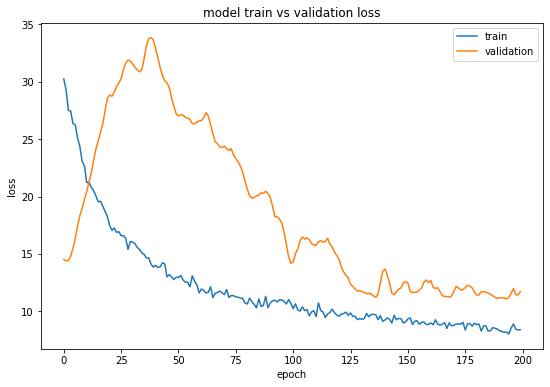

In [12]:
##### Step 6: plot train and validation loss #####
history = model.history
plt.plot(age_range*pd.Series(history.history['mean_absolute_error']))
plt.plot(age_range*pd.Series(history.history['val_mean_absolute_error']))
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [13]:
#### Step 7: test the final model #####
final_model = load_model(model_store)
x_test = x_valid
y_test = y_valid
y_scores = final_model.predict([x_test])
y_scores = y_scores.reshape(y_scores.shape[0])
vals_true = pd.Series(scaler.inverse_transform(y_valid.reshape(-1,1)).reshape(1,-1)[0])
vals_pred = pd.Series(scaler.inverse_transform(y_scores.reshape(-1,1)).reshape(1,-1)[0])
errors = vals_pred - vals_true

count    65.000000
mean      0.215797
std      14.220300
min     -29.210220
25%      -7.905365
50%       0.743896
75%       9.193230
max      39.294212
dtype: float64


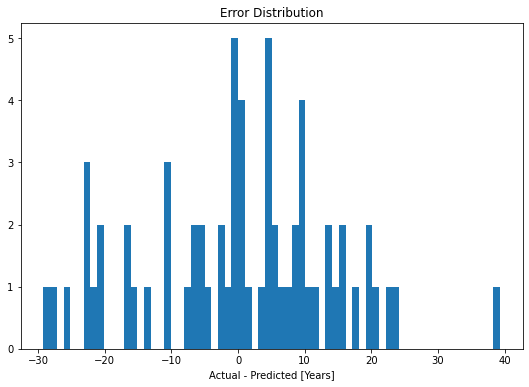

In [14]:
print(errors.describe())
plt.hist(errors, bins=int(errors.max()-errors.min()))
plt.title('Error Distribution')
plt.xlabel('Actual - Predicted [Years]')
plt.show()

count    65.000000
mean     11.081193
std       8.806404
min       0.028870
25%       4.327347
50%       9.193230
75%      16.666084
max      39.294212
dtype: float64


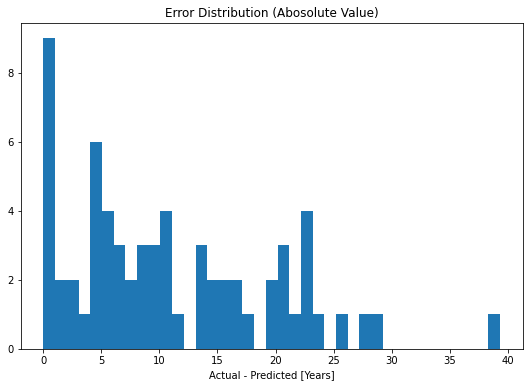

In [15]:
print(errors.abs().describe())
plt.hist(errors.abs(), bins=int(errors.abs().max()-errors.abs().min()))
plt.title('Error Distribution (Abosolute Value)')
plt.xlabel('Actual - Predicted [Years]')
plt.show()

[ 0.55631572 31.57403731]


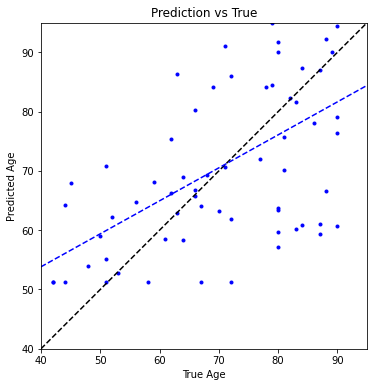

In [16]:
plt.plot(vals_true, vals_pred,'b.')
plt.axis('square')
plt.xlim((40,95))
plt.ylim((40,95))
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Prediction vs True')
plt.plot([40,95],[40,95],'--k')
coef = np.polyfit(vals_true, vals_pred, 1)
print(coef)
poly1d_fn = np.poly1d(coef)
plt.plot([40,95], poly1d_fn([40,95]), '--b')
plt.show()